In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Re-load the dataset
df_new = pd.read_csv('../data/transform/match_details_transformed.csv')

In [2]:
cr = ['Unnamed: 0', 'match_api_id', 'season', 'stage', 'Unnamed: 0']
df_numerical = df_new.drop(cr, axis=1)
df_numerical.to_csv('../data/transform/df_numerical.csv')
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          3040 non-null   object 
 1   away_team                     3040 non-null   int64  
 2   home_team                     3040 non-null   int64  
 3   home_team_goal                3040 non-null   int64  
 4   away_team_goal                3040 non-null   int64  
 5   result_match                  3040 non-null   int64  
 6   away_shoton                   3040 non-null   int64  
 7   away_possession               3040 non-null   int64  
 8   home_shoton                   3040 non-null   int64  
 9   home_possession               3040 non-null   int64  
 10  player_rating_home_player_1   3040 non-null   int64  
 11  player_rating_home_player_2   3040 non-null   int64  
 12  player_rating_home_player_3   3040 non-null   int64  
 13  pla

In [3]:
def remove_highly_correlated_features(df, threshold=0.9, cols_to_remove=['date', 'away_team', 'home_team','home_team_goal',]):
    """
    Removes features from the dataframe that have a correlation coefficient
    higher than the specified threshold.

    Parameters:
    df (pd.DataFrame): Dataframe with numerical features.
    threshold (float): Threshold for high correlation.

    Returns:
    tuple: (set of features to remove, reduced dataframe shape)
    """
    # Calculate the correlation matrix
    correlation_matrix = df.drop(cols_to_remove, axis=1).corr()

    # Find feature pairs with correlation greater than the threshold
    # Interested in absolute value of correlation coefficient
    highly_correlated_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
    highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs >= threshold]
    highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs < 1]  # Remove self-correlation

    # Since correlation is symmetric, we'll take one of each pair
    # We will only take the first of the pair to remove.
    features_to_remove = set([pair[0] for pair in highly_correlated_pairs.index])

    print(features_to_remove)
    df_ = df.drop(columns=features_to_remove)
    print(df_.shape)
    
    return df_

data_reduced = remove_highly_correlated_features(df_numerical)

{'player_rating_away_player_5', 'player_rating_home_player_2', 'home_wins', 'away_wins', 'player_rating_home_player_1', 'player_rating_home_player_5', 'player_rating_home_player_3', 'points_home', 'player_rating_away_player_1', 'player_rating_home_player_6', 'away_team_strength', 'points_away', 'player_rating_away_player_2', 'player_rating_away_player_3', 'home_team_strength', 'player_rating_away_player_6', 'player_rating_home_player_4', 'player_rating_away_player_4'}
(3040, 35)


In [4]:
# Splitting the original dataset
X = data_reduced.drop(['result_match', 'date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton', ], axis=1)
y = data_reduced['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = accuracy_score(y_test, y_pred_full)

accuracy_full

0.5

In [5]:
# Feature engineering: Aggregated player ratings for home and away teams
player_rating_columns_home = [col for col in df_new.columns if 'home_player' in col]
player_rating_columns_away = [col for col in df_new.columns if 'away_player' in col]

# data_cleaned['avg_player_rating_home'] = data_cleaned[player_rating_columns_home].mean(axis=1)
# data_cleaned['avg_player_rating_away'] = data_cleaned[player_rating_columns_away].mean(axis=1)

In [6]:
data_reduced['avg_player_rating_home'] = data_reduced[['player_rating_home_player_7','player_rating_home_player_8','player_rating_home_player_9',
              'player_rating_home_player_10', 'player_rating_home_player_11']].mean(axis=1)

data_reduced['avg_player_rating_away'] = data_reduced[['player_rating_away_player_7','player_rating_away_player_8','player_rating_away_player_9',
              'player_rating_away_player_10', 'player_rating_away_player_11']].mean(axis=1)

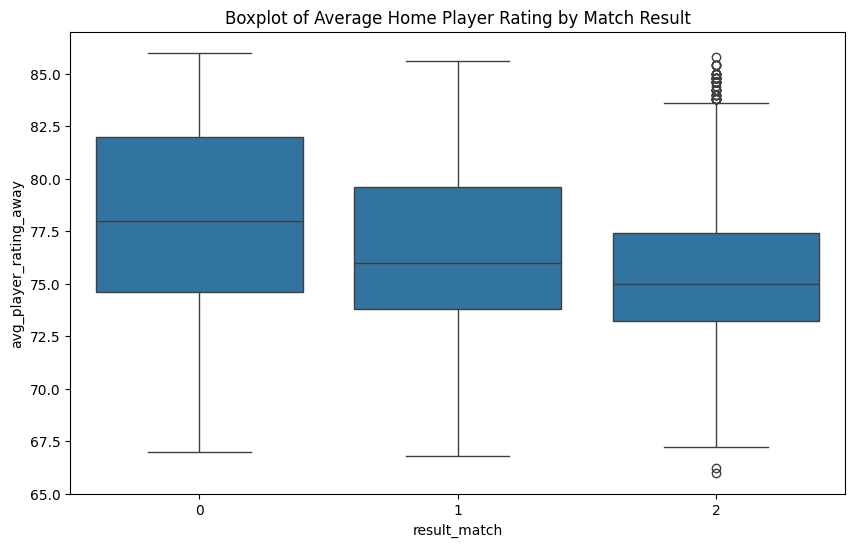

In [7]:
# Boxplot for 'avg_player_rating_home' vs 'result_match'
plt.figure(figsize=(10, 6))
sns.boxplot(x='result_match', y='avg_player_rating_away', data=data_reduced)
plt.title('Boxplot of Average Home Player Rating by Match Result')
plt.show()

In [8]:
# Clear negative correaltion between result_match and avg_palyer_rating_away

In [ ]:
# List of player positions for which we have ratings
player_positions = range(7, 12)

# Calculate the difference from the average for each player
for position in player_positions:
    home_player_col = f'player_rating_home_player_{position}'
    away_player_col = f'player_rating_away_player_{position}'
    
    # Create new features for home and away players
    data_reduced[f'diff_player_{position}'] = data_reduced[home_player_col] - data_reduced[away_player_col]
    # data_reduced.drop([home_player_col, away_player_col], axis=1, inplace=True)

# Display the dataframe to confirm the new features
data_reduced.filter(like='diff_player').columns

In [12]:
df_with_rolling = calculate_rolling_averages(best_window_size, df=data_reduced.copy(), stat_columns=stat_columns)
df_with_rolling = df_with_rolling.drop(['date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton'], axis=1)

In [13]:
# Splitting the original dataset
X = df_with_rolling.drop('result_match', axis=1)
y = df_with_rolling['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = accuracy_score(y_test, y_pred_full)

accuracy_full

0.4967105263157895

In [14]:
df_with_rolling.shape

(3040, 39)

In [15]:
df = df_with_rolling.copy()

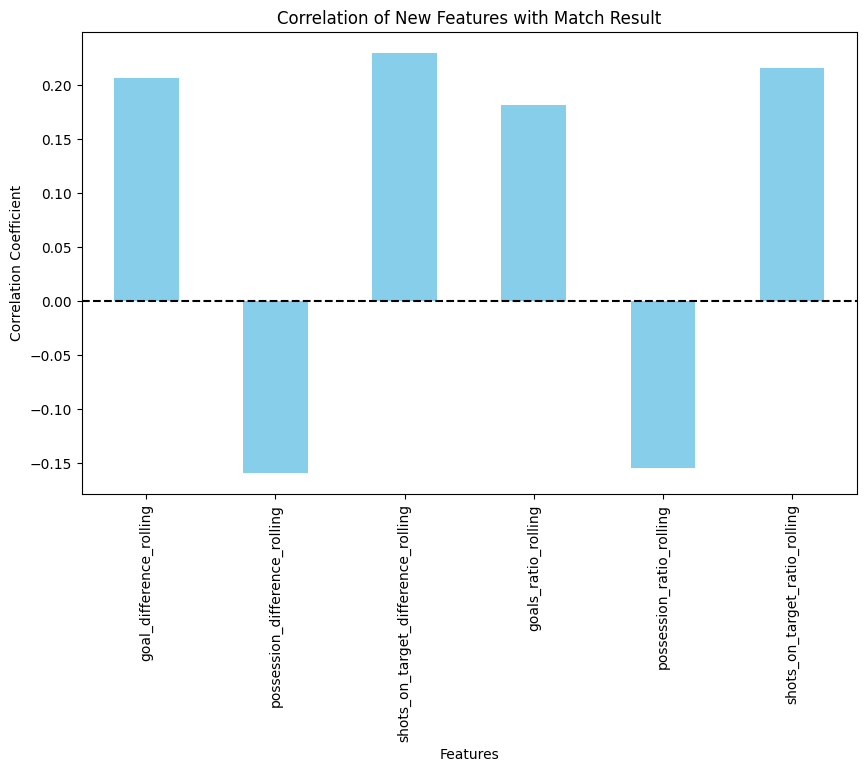

In [16]:
# Assuming 'df' is your original DataFrame

# Creating difference features
df['goal_difference_rolling'] = df['home_goals_rolling'] - df['away_goals_rolling']
df['possession_difference_rolling'] = df['home_possession_rolling'] - df['away_possession_rolling']
df['shots_on_target_difference_rolling'] = df['home_shots_on_rolling'] - df['away_shots_on_rolling']

# Creating ratio features (adding 1 to the denominator to avoid division by zero)
df['goals_ratio_rolling'] = df['home_goals_rolling'] / (df['away_goals_rolling'] + 1)
df['possession_ratio_rolling'] = df['home_possession_rolling'] / (df['away_possession_rolling'] + 1)
df['shots_on_target_ratio_rolling'] = df['home_shots_on_rolling'] / (df['away_shots_on_rolling'] + 1)

# Checking the correlation of the new features with the target variable
correlations = df[['goal_difference_rolling', 'possession_difference_rolling', 
                   'shots_on_target_difference_rolling', 'goals_ratio_rolling', 
                   'possession_ratio_rolling', 'shots_on_target_ratio_rolling', 
                   'result_match']].corr()

# Focusing on the correlation with the target variable 'result_match'
correlations_result_match = correlations['result_match']

# Extracting the correlation values (excluding the last one as it is the correlation of 'result_match' with itself)
correlation_values = correlations_result_match[:-1]

# Creating a bar plot
plt.figure(figsize=(10, 6))
correlation_values.plot(kind='bar', color='skyblue')
plt.title('Correlation of New Features with Match Result')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='k', linestyle='--')  # Adds a horizontal line at y=0 for reference
plt.show()

In [17]:
# Positive correlations are shown by bars extending above the horizontal line (y=0), 
# indicating that an increase in these features is associated with higher values of 'result_match'.

# Negative correlations, shown by bars below the line, 
# suggest that an increase in these features is associated with lower values of 'result_match'.

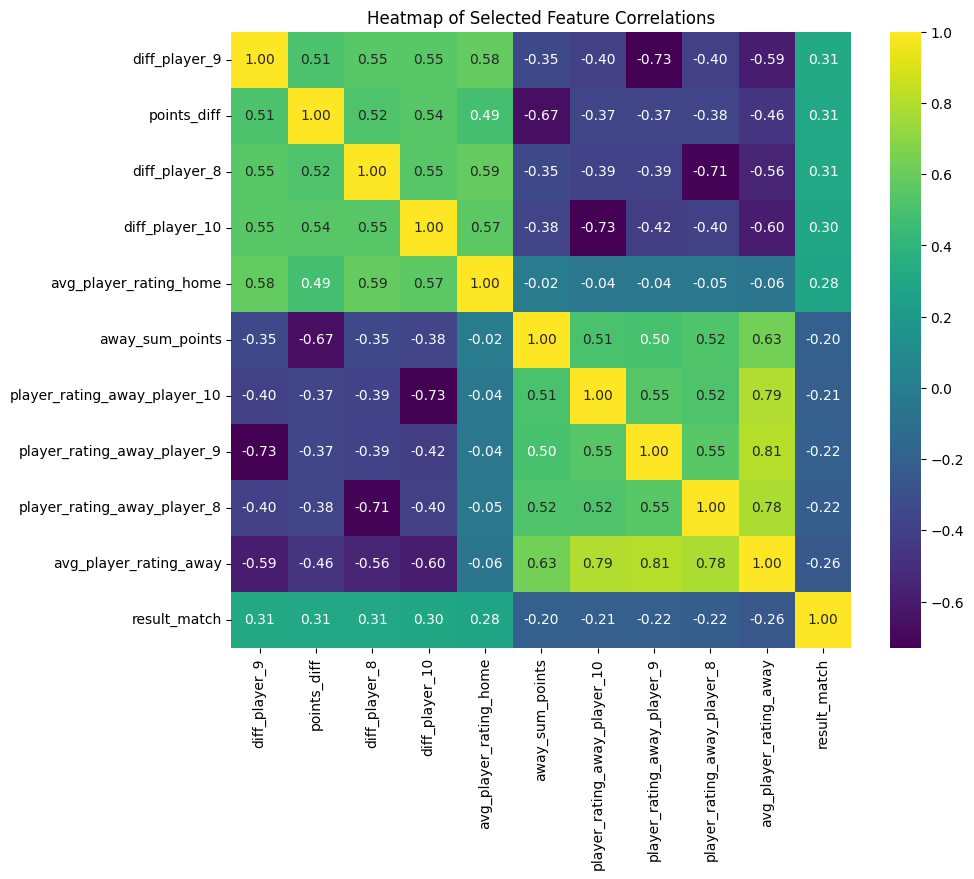

In [18]:
# Calculate the Pearson correlation matrix
correlation_matrix = df.corr()

# Extract the correlations with the target variable 'result_match'
correlations_with_target = correlation_matrix['result_match'].sort_values(ascending=False)

correlations_with_target

# Select the top 5 positively correlated and top 5 negatively correlated features (excluding the target itself)
top_positive_correlated_features = correlations_with_target.index[1:6].tolist()
top_negative_correlated_features = correlations_with_target.index[-5:].tolist()
selected_features = top_positive_correlated_features + top_negative_correlated_features

# Create a new dataframe with the selected features and the target variable
selected_data = df[selected_features + ['result_match']]

# Create a heatmap for the selected features
plt.figure(figsize=(10, 8))
sns.heatmap(selected_data.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap of Selected Feature Correlations')
plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3040 entries, 386 to 3016
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   result_match                        3040 non-null   int64  
 1   player_rating_home_player_7         3040 non-null   int64  
 2   player_rating_home_player_8         3040 non-null   int64  
 3   player_rating_home_player_9         3040 non-null   int64  
 4   player_rating_home_player_10        3040 non-null   int64  
 5   player_rating_home_player_11        3040 non-null   int64  
 6   player_rating_away_player_7         3040 non-null   int64  
 7   player_rating_away_player_8         3040 non-null   int64  
 8   player_rating_away_player_9         3040 non-null   int64  
 9   player_rating_away_player_10        3040 non-null   int64  
 10  player_rating_away_player_11        3040 non-null   int64  
 11  home_avg_goals_scored               3040 non-n

In [20]:
# # Interaction Features: Creating a few examples of interaction features
# df['interaction_home_player_7_8'] = df['player_rating_home_player_7'] * df['player_rating_home_player_8']
# df['interaction_away_player_7_8'] = df['player_rating_away_player_7'] * df['player_rating_away_player_8']
# df['interaction_home_away_possession'] = df['avg_possession_home'] * df['avg_possession_away']

# # Polynomial Features: Generating polynomial features (degree 2 for demonstration)
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# X_poly = poly.fit_transform(df[original_features])

# # Adding polynomial features to the DataFrame
# poly_feature_names = poly.get_feature_names_out(input_features=original_features)
# df_poly = pd.DataFrame(X_poly, columns=poly_feature_names)

# # Merging polynomial features with the original dataset
# df_extended = pd.concat([df, df_poly], axis=1)
# df_extended = df_extended.loc[:,~df_extended.columns.duplicated()]

# # Showing a few new features
# df_extended[['interaction_home_player_7_8', 'interaction_away_player_7_8', 'interaction_home_away_possession', 
#              ]].head()

In [21]:
# print(df_extended.shape)

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

# Clustering as a Feature
# Using KMeans for clustering; the number of clusters is set arbitrarily to 5 for demonstration
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df.drop('result_match', axis=1))

# Showing a few rows of the dataset with new features
df[['cluster', ]].head()

,cluster
386,0
412,3
423,3
441,3
464,0


In [23]:
print(df.shape)

(3040, 46)


In [24]:
# df = remove_highly_correlated_features(df, 0.8, [])

In [25]:
# df.shape

In [26]:
# Splitting the original dataset
X = df.drop('result_match', axis=1)
y = df['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = accuracy_score(y_test, y_pred_full)

accuracy_full

0.4934210526315789

In [180]:
import os

output_dir = "../data/transform/"
filename= "df_rolling.csv"

full_path = os.path.join(output_dir, filename)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df.to_csv(full_path)